<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 15th August, 2023
# Click through rate prediction
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In [7]:
# -0.2 WARN Will delete all earlier work

#   Delete all avazu data, if it exists
#   Cleanup earlier saved data:

from pathlib import Path
avazufolder = Path("D:\\avazu\\allmodels\\")

if avazufolder.exists():
    shutil.rmtree(avazufolder)

## Basics

In [2]:
# 0.1 Install from pypi:
%reset
!pip install catencfamily==0.0.89

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 0.2 Easy to format columns into tables:

! pip install python-tabulate

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement python-tabulate (from versions: none)
ERROR: No matching distribution found for python-tabulate


In [267]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time


# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE  # Not used
from sklearn.metrics import classification_report,f1_score,roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
# 1.0.7 Our folders:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..  
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 1.0.8 Create all these folders:

avazufolder.mkdir(parents=True, exist_ok=True)
avazugraphs.mkdir(parents=True, exist_ok=True)
avazudata.mkdir(parents=True, exist_ok=True)
avazuestimators.mkdir(parents=True, exist_ok=True)
avazuunitvecs.mkdir(parents=True, exist_ok=True)


In [10]:
# 1.0.9 Decide program-wide random state:

rng= np.random.RandomState(None)

## Taking a sample of data


In [11]:
## 1.1 We will extract data randomly from disk using the following code

dataPath = "D:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000   # Earlier: 20l

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",  
                     header=0,  
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),   
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes

_= gc.collect()

load train...


In [13]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)/(1999324, 24)
train.head(3)

(1999324, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000640724480838376,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
1,10007847530896919634,1,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21661,320,50,2446,3,171,100228,156
2,10009190848778773294,0,2014-10-21,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,1,0,16920,320,50,1899,0,431,-1,117


In [14]:
# 1.3.2 Imbalanced data:
train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)  # 83%:17%

0    1660350
1     338974
Name: click, dtype: int64

0    0.830456
1    0.169544
Name: click, dtype: float64

In [16]:
# 1.3.3
train.dtypes


id                          uint64
click                        uint8
hour                datetime64[ns]
C1                          uint16
banner_pos                   uint8
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  uint8
device_conn_type             uint8
C14                         uint16
C15                         uint16
C16                         uint16
C17                         uint16
C18                          uint8
C19                         uint16
C20                          int32
C21                          int64
dtype: object

In [17]:
# 1.3.4 Separate target, and drop id

y = train.pop("click")
_= train.pop("id")

In [197]:
# 1.3.5 Our list of columns:

print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid', 'appdomain', 'appcategory', 'deviceid', 'deviceip', 'devicemodel', 'devicetype', 'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen', 'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone', 'month', 'dayofweek', 'day', 'hour_time']


In [19]:
# 2.0 Check no of unique values in every column
# Two columns, device_id and device_ip,
# have very large no of unique values:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name            No of unique values
----------------  ---------------------
hour                                240
C1                                    7
banner_pos                            7
site_id                            3054
site_domain                        3541
site_category                        24
app_id                             3924
app_domain                          247
app_category                         28
device_id                        278901
device_ip                        963650
device_model                       5770
device_type                           5
device_conn_type                      4
C14                                2361
C15                                   8
C16                                   9
C17                                 423
C18                                   4
C19                                  66
C20                                 167
C21                                  60


In [20]:
# 2.1 Rename columns as per requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_ip"     : "deviceip",
        "device_id"      : "deviceid",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)/(1999324, 22)
train.head(3)

(1999324, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15706,320,50,1722,0,35,100084,79
1,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,767a174e,...,0,0,21661,320,50,2446,3,171,100228,156
2,2014-10-21,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,16920,320,50,1899,0,431,-1,117


### Extract date components

In [21]:
# 2.2 Extract date components then del 'hour' column:

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,...,50,1722,0,35,100084,79,10,1,21,0
1,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,767a174e,3e805b2a,...,50,2446,3,171,100228,156,10,1,21,0


## Label Encoding cat cols

In [22]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept categorical columns.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,0,1fbe01fe,f3845767,28905ebd
1,1002,0,84c7ba46,c4e18dd6,50e219e0


,appid,appdomain,appcategory,deviceid,deviceip
0,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f
1,ecad2386,7801e8d9,07d7df22,767a174e,3e805b2a


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,6332421a,1,0,15706,320
1,cf19f7f7,0,0,21661,320


In [23]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "deviceid", "deviceip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:

train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,1fbe01fe,f3845767,ecad2386,7801e8d9
1,84c7ba46,c4e18dd6,ecad2386,7801e8d9


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,07d7df22,a99f214a,e8275b8f,6332421a,28905ebd
1,07d7df22,767a174e,3e805b2a,cf19f7f7,50e219e0


In [24]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # To save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()



In [25]:
# 3.2 Check again if encoding done?

train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,361,3365,3617,110
1,1598,2741,3617,110
2,1164,320,3617,110


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,0,184577,873873,2226,1
1,0,128822,235293,4665,5
2,0,184577,950529,2531,22


## Partition data

In [26]:
######################
######################

# 4.0 Split our data
X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)/(1499493, 25)
X_test.shape     # (500374, 25)/(499684, 25)/(499831, 25)
y_train.shape    # (1501119,)/(1499049,)/(1499493,)
y_test.shape     # (500374,)/(499684, )/(499831,)

(1499493, 25)

(499831, 25)

(1499493,)

(499831,)

In [27]:
# 4.1 Check nulls. None.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [28]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.830455
1    0.169545
Name: click, dtype: float64

0    0.830456
1    0.169544
Name: click, dtype: float64

## Save all data files 
This is for future use

### Cleanup earlier data

In [32]:
# SKIP this STEP if YOU EXECUTED
# CODE at -0.2
"""
# 5.0 Delete avazufolder, if it exists
#     Cleanup earlier data:

path = avazufolder
if path.exists():
    shutil.rmtree(avazufolder)
    
# 5.1 Create folder and a subfolder that we may use:

p = avazudata
p.mkdir(parents=True, exist_ok=True)

"""

### Save and check

In [33]:
# 6.0 Save the dict of LabelEncoder objects for future use:


utils.savePythonObject( dict_, "labelEnoders.pkl", avazudata)


# 6.1 Save also label encoded train data:

train.to_pickle( Path(avazudata) / "train_encoded.pkl")
y.to_pickle(Path(avazudata) / "y.pkl")


# 6.2 Also save partitioned data:

X_train.to_pickle(Path(avazudata) / "X_train.pkl")
X_test.to_pickle(Path(avazudata) / "X_test.pkl")
y_train.to_pickle(Path(avazudata) / "y_train.pkl")
y_test.to_pickle(Path(avazudata) / "y_test.pkl")


# 6.3 Finally list all files that we have got here:

list(Path(avazudata).iterdir())

Object saved to: D:\avazu\allmodels\datafiles\labelEnoders.pkl


[WindowsPath('D:/avazu/allmodels/datafiles/labelEnoders.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/train_encoded.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/X_test.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/X_train.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/y.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/y_test.pkl'),
 WindowsPath('D:/avazu/allmodels/datafiles/y_train.pkl')]

In [34]:
X_train.shape   # (1499493, 25)
X_train.head(2)

(1499493, 25)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
378853,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1856378,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


## Instantiate and fit `CatEncodersFamily` class

In [35]:
# 7.0 Which are our cat columns

# 7.1 We cosider all except deviceid and deviceip
#     These two columns as we will shortly see are not important:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']   # , 'deviceid', 'deviceip'] 

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:
#     device_id and device_ip have very large number of levels
#     So we have ignored them in our above list.

rem_cols =  set(train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")

rem_cols:  '{'day', 'hour_time', 'month', 'dayofweek'}'  #  But we exclude deviceid and deviceip

# 7.3 As number of cat_cols are quite large
#  Keep interacting columns as null

interactingCatCols = []


No of cat_cols is: 19
Remaining columns are: '{'deviceid', 'dayofweek', 'month', 'hour_time', 'deviceip', 'day'}'


In [36]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = avazugraphs , # Folder to store graph files
                                                    # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder , # Progress recorded in *.csv files
                        saveGraph = True   # Save all *.gml files
                       )

# 8.0.1 Fit it on X_train:

gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 66 minutes

8

Record set no is 1  
Set of records is:  [('siteid', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appid', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('sitedomain', 'Cone', [1, 1, 1, 0, N

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

64.9135559797287


### Save `CatEncodersFamily` object
Maybe for later use

In [37]:
# 8.1 Save the fitted class object for later use:
utils.savePythonObject(ct, "transformer.pkl", avazudata)

# 8.1.1 We can delete existing class object
del ct

# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

Object saved to: D:\avazu\allmodels\datafiles\transformer.pkl


CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

## Data transformation

In [38]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 29min
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 6957.64752 MB
Mem usage after dtype transformation is: 3526.807536 MB
29.372187932332356


In [39]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 13 min
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 2319.21584 MB
Mem usage after dtype transformation is: 1175.602512 MB
13.923742481072743


0

In [40]:
# 8.3 Check shapes:

train_trans.shape      # (1499493, 591)
test_trans.shape       #  (499831, 591)


(1499493, 591)

(499831, 591)

## Save transformed data

In [41]:
# 9.0 Save transformed data to avazufolder:

gc.collect()
train_trans.to_pickle(Path(avazudata) / "train_trans.pkl")
test_trans.to_pickle(Path(avazudata) / "test_trans.pkl")

0

## Read transformed data
Read back all saved/processed data

In [ ]:
#####################################
## Start reading all saved data files
#####################################

In [42]:
# 9.1 Our data folders. Just to recall:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"  # For *.pkl files
avazuestimators = avazufolder / "estimators"  # For fitted estimators. Not used
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [60]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check:

train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)/(2249004, 779)/(1499493, 591)
y_train.shape       # (1501119,),(1499049,),(1499493,)
test_trans.shape    # (500374, 599)/(499684, 595)/(749668, 779),(499831, 591)
y_test.shape        # (500374,)/(499684,),(499831,)

# 
rem_cols = {'day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip'}
_=gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

In [44]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone'] # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'deviceid', 'deviceip']  # 6 cols

In [45]:
# 9.4 Concat first four rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols:

cols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat but only Ist four rem_cols:

X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)/(2250941, 586)/(1499493, 576)
X_test_trans.shape   # (500374, 586)/(499684, 582)/(750314, 586)/(499831, 576)

(1499493, 576)

(499831, 576)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original discrete data

In [49]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[08:29:35] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[08:29:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10782 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74773	validation_1-auc:0.72898
[08:29:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10048 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75347	validation_1-auc:0.73339
[08:29:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10428 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75671	validation_1-auc:0.73566
[08:29:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10918 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.75912	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [51]:
# 10.0.1 Save model object:

utils.savePythonObject(model_orig, "model_orig.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_orig.pkl


In [52]:
# 10.0.2 Restore model object:

model_orig = utils.restorePythonObject("model_orig.pkl", avazudata)

In [191]:
# 10.1 Best Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  #  0.75073109205036
                                                                # 
print("===========")  # 0.7501188549887546'   
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 156


'Best auc from orig train/test data: 0.7507310920503643'

'Best iteration from orig train/test data: 156'

### xgboost model with transformed data (only)
Only transformed data and none of original cat columns

In [53]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

[08:36:21] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[08:36:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10482 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75162	validation_1-auc:0.73371
[08:36:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9868 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75963	validation_1-auc:0.73947
[08:36:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10472 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76293	validation_1-auc:0.74142
[08:37:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10124 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76495	v

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [54]:
# 10.2.1 Save model object:

utils.savePythonObject(model_trans, "model_trans.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans.pkl


In [55]:
# 10.2.2 Restore model object:

model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)

In [56]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7531621285335741(20L)
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);70(20L)

'Best auc from transformed train/test data: 0.7531621285335741'

'Best iteration from transformed train/test data: 70'

In [77]:
# 10.4 Prepare xgboost model--Original data
#      But without device_id and device_ip

Xtr = X_train.copy()
Xte = X_test.copy()
_=Xtr.pop('deviceid')
_=Xtr.pop('deviceip')
_=Xte.pop('deviceip')
_=Xte.pop('deviceid')

model_orig_noip = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   Xtr
test_X = Xte
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig_noip.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[09:14:38] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:14:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10666 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74631	validation_1-auc:0.73101
[09:14:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10540 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75209	validation_1-auc:0.73457
[09:14:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10548 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75483	validation_1-auc:0.73636
[09:14:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10800 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.75665	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [79]:
# 10.4.1 Save and restore:
utils.savePythonObject(model_orig_noip, "model_orig_noip.pkl", avazudata)
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_orig_noip.pkl


In [190]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_orig_noip.best_score}"  # 0.7528(15L); 0.7538(20L);  0.7506422630703(20L)
print("===========")
f"Best iteration from transformed train/test data: {model_orig_noip.best_iteration}"  # 82(15L) 117(20L);136(20L)

'Best auc from transformed train/test data: 0.7506422630700963'

'Best iteration from transformed train/test data: 136'

### Classification reports

In [81]:
# 10.4 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.60      0.09      0.15     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374

"""

In [82]:
# 10.5 Original data without deviceid and deviceip

pred = model_orig_noip.predict(Xte)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.59      0.09      0.16     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [83]:
# 10.5 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.59      0.09      0.16     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
"""
 precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


"""

### Feature importance

In [84]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405
print("\n")
len(fe_0)   # 172;177
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


415

161

,imp
eig_Cfourteen_ck_Ceighteen,0.323855
eig_Ctwentyone_ck_devicemodel,0.167575
pr_Ctwentyone_ck_devicemodel,0.026783
deg_Cseventeen_ck_Csixteen,0.025131
pr_Ctwentyone_ck_appid,0.024722


### xgboost model only with transformed data but impt features

In [85]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[09:20:27] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:20:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10792 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75221	validation_1-auc:0.73351
[09:20:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10526 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75996	validation_1-auc:0.73950
[09:20:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10004 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76298	validation_1-auc:0.74134
[09:21:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9736 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76643	v

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [86]:
# 11.1.1 Save model object:

utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans_impt.pkl


In [87]:
# 11.1.2 Restore model object:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

#### Classification reports
Classification report of model with transformed data having impt features

In [88]:
# 11.2 Classification report of transformed data but with impt features:

model_trans.best_score    # 0.753373650(40L)
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.7531621285335741

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.59      0.09      0.16     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


                   precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



"""

## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
>Model with original data but without deviceid and deviceip<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

As the plots show:  
- Learning plots with transformed data show AUC which is shade better than that with original data<br>
- Learning plots of original data with and without deviceid and deviceip are same 


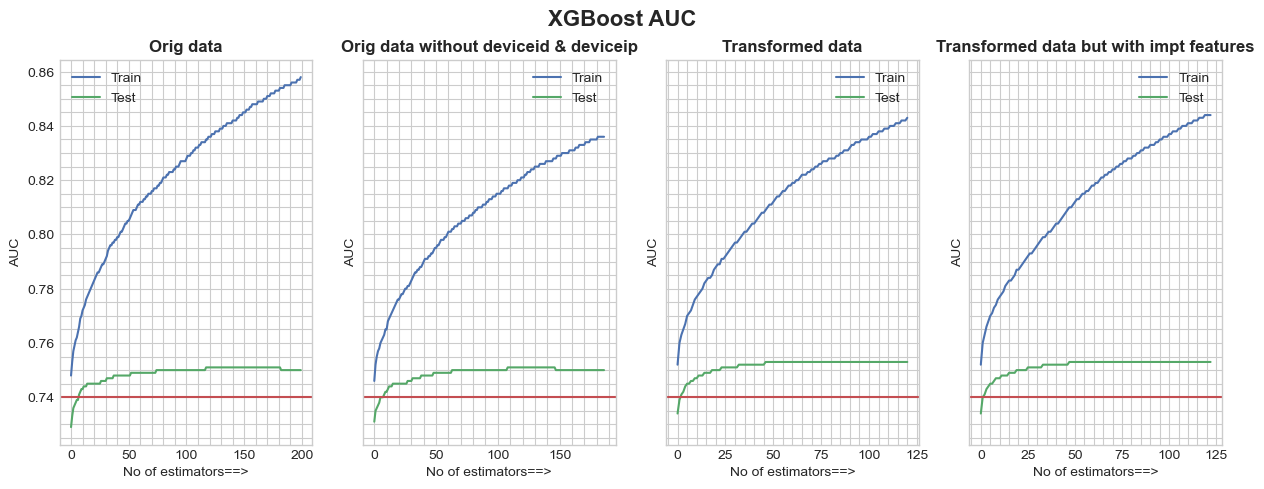

In [200]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-deep')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(), model_orig_noip.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Orig data", 'Orig data without deviceid & deviceip', 'Transformed data', 'Transformed data but with impt features']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 16)

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1.5, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1.5, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>');
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();



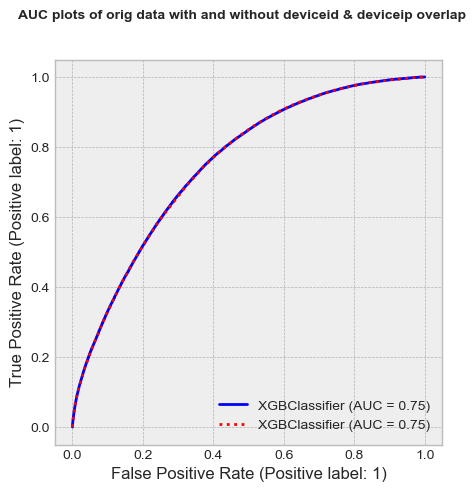

In [389]:
# 12.1 AUC plots of original data with deviceid and deviceip 
#      and of original data without deviceid and deviceip:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("AUC plots of orig data with and without deviceid & deviceip overlap", fontweight = "bold", fontsize = 10);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue");
RocCurveDisplay.from_estimator(model_orig_noip, Xte, y_test, ax = ax, color = 'red',linestyle = ":" );


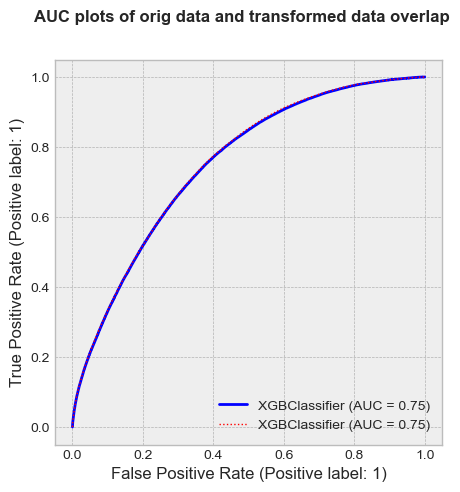

In [391]:
# 12.2 AUC plots of original data and of transformed data:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("AUC plots of orig data and transformed data overlap", fontweight = "bold", fontsize = 12);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue");
RocCurveDisplay.from_estimator(model_trans, X_test_trans, y_test, ax = ax, color = 'red',linestyle = ":" , linewidth =1);


## Preparing for PCA--imputing data
PCAs of transformed data 

In [91]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 63060


0

63060

In [92]:
# 13.1 Impute as test data has null values:

pca_train = X_train_trans.copy()
pca_test  = X_test_trans.copy()  
_=gc.collect()

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)
end = time.time()
print("Done: ", (end-start)/60)  # 8 min

Imputing....
Done:  8.002142628033956


In [94]:
# 13.1.1 Check for nulls again:

pca_train.isnull().sum().sum()  # 0
pca_test.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [95]:
# 13.2 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train_imputed.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test_imputed.pkl")

# 13.2.0 Datashapes
pca_train.shape  # (1501119, 586)/(1499049, 582)
pca_test.shape   # (500374, 586)/(499684, 582)

(1499493, 576)

(499831, 576)

### Read imputed data

In [96]:
# 13.2.1 Read back saved pca_train and pca_test data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train_imputed.pkl")
pca_test = pd.read_pickle(Path(avazudata) / "pca_test_imputed.pkl")

# 13.2.2 Check
pca_train.shape  # (1501119, 586)/(1499493, 576)
pca_test.shape   # (500374, 586)/(499831, 576)

(1499493, 576)

(499831, 576)

### Perform 95% PCA 

In [97]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95


pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)
pca_test.shape   # (500374, 97)/(499831, 96)

(1499493, 96)

(499831, 96)

In [98]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.4.1 Dataframe shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)
pca_test.shape   # (500374, 97)/(499831, 96)

(1499493, 96)

(499831, 96)

### Plotting PCA

In [99]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)
pca_y.shape   # (5000,)

(5000, 96)

(5000,)

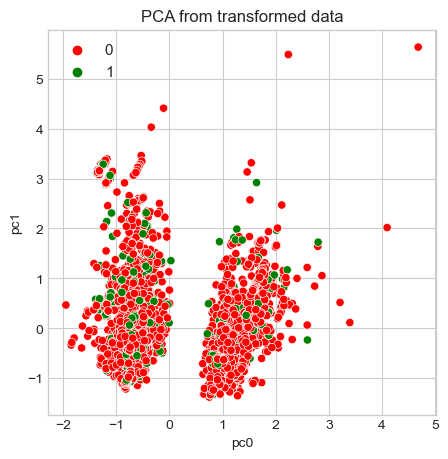

In [100]:
# 13.6 2D PCA plot from first two principal components:
#      Two clusters are evident:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

### Save 95% PCA data

In [101]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test.pkl")

### Read back 95% PCA data

In [394]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc86,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95
0,1.157654,-0.759549,-1.279916,-0.109048,0.549666,1.022912,-0.244290,0.993298,-0.163661,-0.902705,...,0.256286,0.065603,1.175083,0.769337,0.426587,-0.816391,0.635097,0.651056,-0.423840,-1.020196
1,1.150145,0.179111,-0.693946,-0.731859,-1.040746,-0.792808,0.600540,-0.390367,1.037805,-0.176131,...,-1.913568,1.335108,-1.184215,2.098298,0.656890,0.625002,-0.312708,-0.221802,0.635871,-1.179480
2,1.199397,-0.852900,-0.983685,-0.209286,0.498151,0.754697,0.488397,1.043141,-0.534350,-0.927434,...,0.668130,-0.262751,0.967242,0.155546,1.194274,-0.627855,-0.753458,0.372976,-0.359437,-0.914057


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc86,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95
0,1.710244,1.138284,1.492376,0.960442,0.381219,-0.029634,0.674488,0.877313,-0.772034,0.236323,...,-1.110194,0.661316,0.671899,2.161002,-3.080022,0.585655,2.670185,-1.681113,-0.042096,3.436856
1,-0.442070,0.877700,2.019071,0.033119,-0.211096,-0.092514,0.997633,0.327515,-1.081467,0.547948,...,-1.249398,-0.129815,0.875367,-0.367375,2.543793,1.030480,-3.649801,-2.123448,1.028076,1.682187
2,0.998662,-0.687000,-1.139412,0.021796,-0.416198,0.604764,0.175508,1.494028,0.890522,-0.442234,...,-0.110098,-1.544569,0.501075,0.006902,-0.032629,0.029386,-0.949449,0.218078,-0.287350,0.308036


### xgboost modeling with all the PCA components

In [103]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit of class weights:

class_weights = {0: 1, 1: 10}

model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,   
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train     
ytest = y_test       


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[11:12:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:12:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:12:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8688 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.73606	validation_1-auc:0.70855
[11:12:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8160 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75003	validation_1-auc:0.71878
[11:12:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8448 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75634	validation_1-auc:0.72265
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.06,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [107]:
# 15.0.2 Save model object:

utils.savePythonObject(model_pca, "model_pca.pkl", avazudata)


Object saved to: D:\avazu\allmodels\datafiles\model_pca.pkl


In [108]:
# 15.0.3 Restore model object:

model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

In [109]:
# 15.1 Best Scores:

model_pca.best_score     # 0.737592962/0.737141317(40L)/0.739549193473(20L)
model_pca.best_iteration # 62/87

0.7395491934732388

66

### Classification report
xgboost modeling with PCA data

In [110]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.58      0.08      0.14     84744

    accuracy                           0.83    499831
   macro avg       0.71      0.53      0.52    499831
weighted avg       0.80      0.83      0.78    499831



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

### Learning curve
xgboost modeling with PCA data

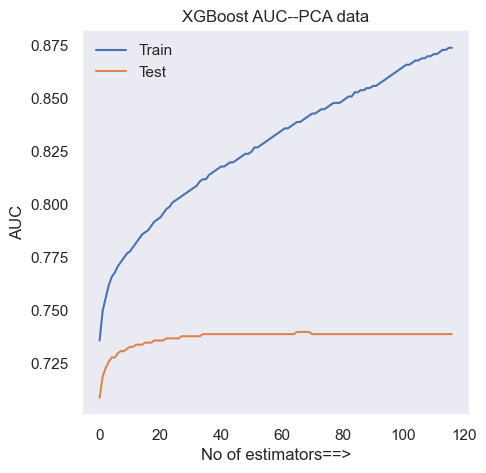

In [111]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_xlabel('No of estimators==>')
ax.set_title("XGBoost AUC--PCA data");

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

In [393]:
# 16.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours  
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`
Undersamples majority class

In [395]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 29min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1091067, 96)
y_res.shape  #  (1075328,)/(1074577, )/(1091067,)

28.983370729287465


(1091067, 96)

(1091067,)

### Plot of Ist two components of cleanedup data

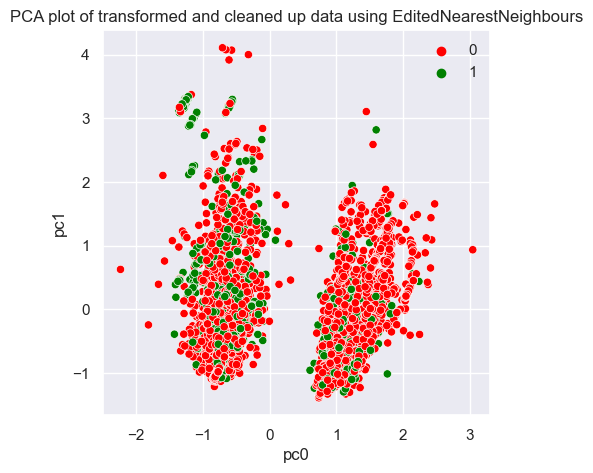

In [114]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [414]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 8,# Needs to be reduced
                               subsample = 0.9,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



[09:29:35] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.72828	validation_1-auc:0.66776
[09:29:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.74747	validation_1-auc:0.68231
[09:29:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.75568	validation_1-auc:0.68840
[09:29:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.75789	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [416]:
# 17.3.1:

utils.savePythonObject(model_en, "model_en.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_en.pkl


In [417]:
# 17.3.2

model_en = utils.restorePythonObject("model_en.pkl", avazudata)

In [418]:
# 17.4 Scores:

model_en.best_score     # 0.738117/0.739586872501523(20L)
model_en.best_iteration # 78/42

0.7395868725015234

556

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [419]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    415087
           1       0.37      0.37      0.37     84744

    accuracy                           0.79    499831
   macro avg       0.62      0.62      0.62    499831
weighted avg       0.79      0.79      0.79    499831



In [ ]:
"""
                precision    recall  f1-score   support 

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data

In [421]:
# 18.0 Instantiate SMOTEEN and use it on pca_train

start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm, y_res_sm = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 96m (20L)

97.69637617270152


(1091067, 96)

(1091067,)

In [422]:
# 18.0.1 Data shape after SMOTEENN

X_res_sm.shape  # (1688427, 97)/(1558844, 96)
y_res_sm.shape  # (1688427,),(1558844,)

(1558844, 96)

(1558844,)

In [423]:
# 18.0.2 
y_res_sm.value_counts()
y_res_sm.value_counts(normalize = True)  # 51%:48%

1    805821
0    753023
Name: click, dtype: int64

1    0.516935
0    0.483065
Name: click, dtype: float64

### Plot of Ist two components of cleanedup data

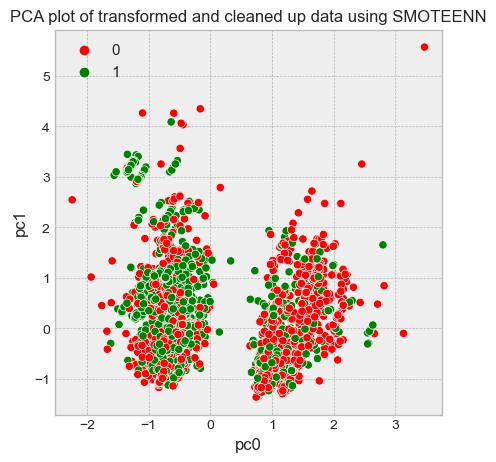

In [424]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res_sm, y_res_sm, test_size = 5000, stratify = y_res_sm)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (SMOTEENN)

In [425]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 650,   # Reduce it
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,     # Reduce it
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res_sm 
test_X = pca_test
ytrain = y_res_sm 
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 100,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[12:03:54] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:04:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1210 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.81116	validation_1-auc:0.69215
[12:04:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1186 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.81943	validation_1-auc:0.69748
[12:04:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1202 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.82523	validation_1-auc:0.70076
[12:04:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1216 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.83090	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [426]:
# 19.0.1
utils.savePythonObject(model_sm, "model_sm.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_sm.pkl


In [427]:
# 19.0.2
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

In [428]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.73260329129(20L)
model_sm.best_iteration  # 230

0.7326032912505788

230

### Classification report
After balancing with `SMOTEENN` class 

In [429]:
# 19.2 
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74    415087
           1       0.28      0.73      0.40     84744

    accuracy                           0.63    499831
   macro avg       0.60      0.67      0.57    499831
weighted avg       0.81      0.63      0.68    499831



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

### Learning plots
xgboost modeling with the two class balancing techniques

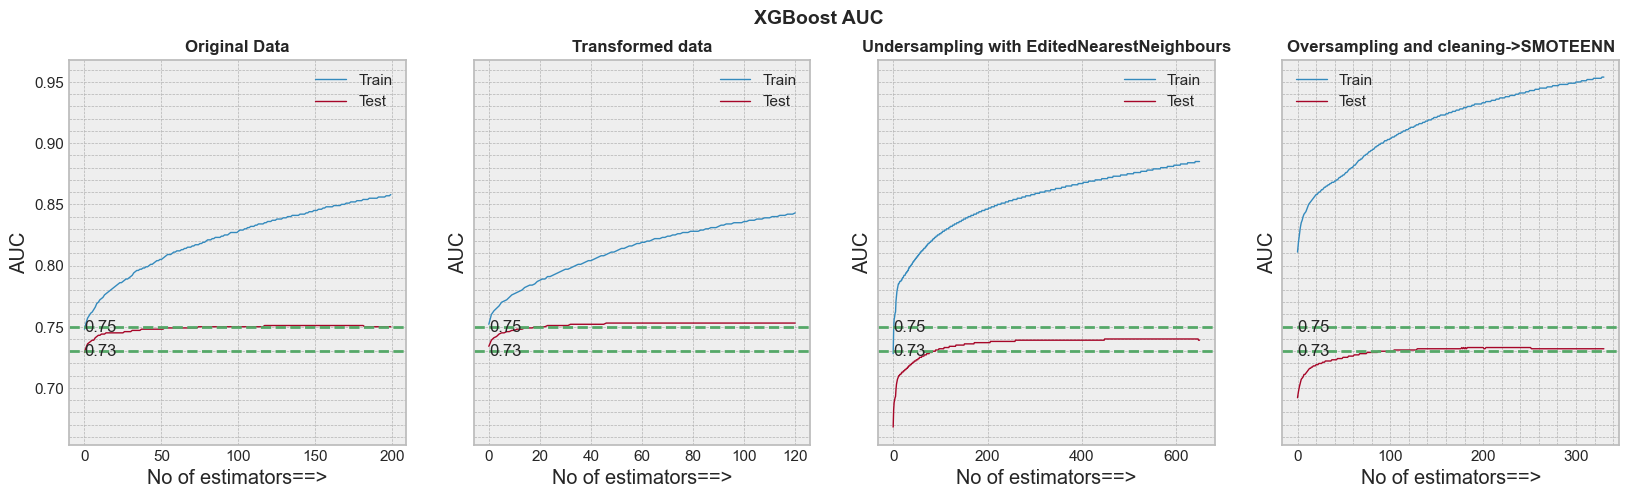

In [430]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('bmh')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result()]
title = ["Original Data", "Transformed data", "Undersampling with EditedNearestNeighbours", 'Oversampling and cleaning->SMOTEENN']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 14)
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.75, color='g', linestyle='--', label='p=0.05')
    ax[i].axhline(y=0.73, color='g', linestyle='--')
    ax[i].text(0, 0.75, '0.75', ha='left', va='center')
    ax[i].text(0, 0.73, '0.73', ha='left', va='center')
   
plt.show();

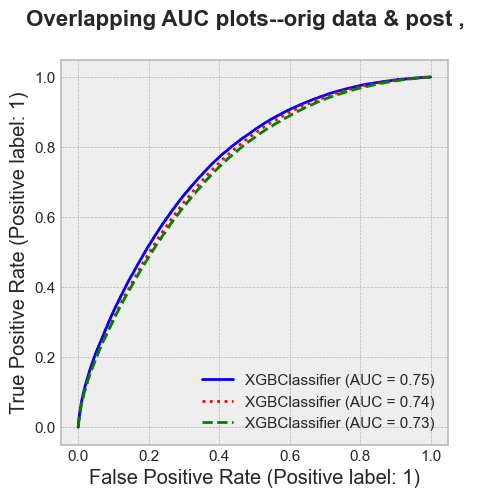

In [431]:
# 19.3.1 AUC plots:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("Overlapping AUC plots--orig data & post , ", fontweight = "bold", fontsize = 16);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue", );
RocCurveDisplay.from_estimator(model_en, pca_test, y_test, ax = ax, color = 'red',linestyle = ":" , linewidth =2);
RocCurveDisplay.from_estimator(model_sm, pca_test, y_test, ax = ax, color = 'green',linestyle = "--" , linewidth =2);

## Cohen's Kappa, Matthews correlation coefficient and F1-score

### Kappa for model with original data:

In [432]:
y1 = model_orig.predict(X_test)
ck_orig = cohen_kappa_score(y_test,y1)    
ck_orig    # 0.11257330895233153

0.11257330895233153

### Kappa for model with transformed data

In [433]:
y1 = model_trans.predict(X_test_trans)
ck_trans = cohen_kappa_score(y1,y_test)    # 0.11912953935895365
ck_trans    #  0.11912953935895365

0.11912953935895365

### Kappa for model with data processed using  `EditedNearestNeighbours`

In [434]:
y1 = model_en.predict(pca_test)
ck_en = cohen_kappa_score(y1,y_test)   
ck_en    # 0.23512337449863685

0.23991363616234762

### Kappa for model with data processed using `SMOTEENN`

In [435]:
y1 = model_sm.predict(pca_test)
ck_sm = cohen_kappa_score(y1,y_test)   
ck_sm   # 0.2059553018588994

0.20923966237004943

### Matthews correlation coefficient for model with original data

In [436]:
y1 = model_orig.predict(X_test)
mcc_orig = matthews_corrcoef(y_test,y1)   # 0.18001543725080113
mcc_orig   # 0.18001543725080113

0.18001543725080113

### Matthews correlation coefficient for model with transformed data

In [437]:
y1 = model_trans.predict(X_test_trans)
mcc_trans = matthews_corrcoef(y_test,y1)   # 0.185746655042
mcc_trans  # 0.185746655042

0.18574665504209525

### Matthews correlation coefficient for model with  `EditedNearestNeighbours`

In [438]:
y1 = model_en.predict(pca_test)
mcc_en = matthews_corrcoef(y_test,y1)
mcc_en #0.2351474205514198

0.23991370158948727

### Matthews correlation coefficient for model with `SMOTEENN` data

In [439]:
y1 = model_sm.predict(pca_test)
mcc_sm = matthews_corrcoef(y_test,y1)    
mcc_sm # 0.256392613027669


0.2594282693638649

In [440]:
# F1 score for different models:

f1_orig = f1_score(y_test, model_orig.predict(X_test))
f1_trans = f1_score(y_test, model_trans.predict(X_test_trans))
f1_en = f1_score(y_test, model_en.predict(pca_test))
f1_sm = f1_score(y_test, model_sm.predict(pca_test))


In [441]:
# Add labels to bar chart
# Ref: https://stackoverflow.com/a/48372659/3282777

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

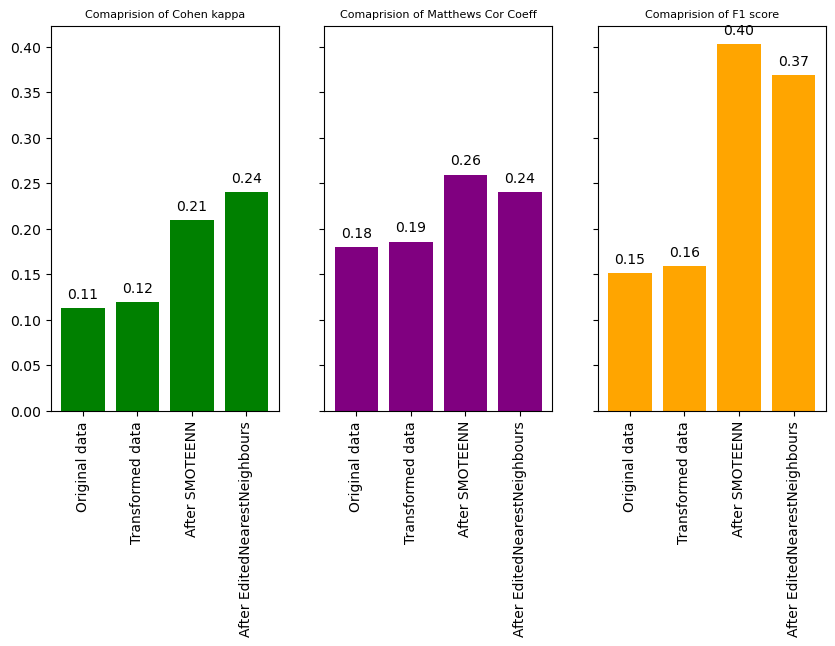

In [448]:
# Combined plots:
plt.style.use('default')
fig,ax = plt.subplots(1,3,sharey = True, figsize= (10,5))
xlabels = ['Original data', 'Transformed data', 'After SMOTEENN', 'After EditedNearestNeighbours']
yvalues_ck = [ck_orig,ck_trans,ck_sm,ck_en]
yvalues_mcc = [mcc_orig,mcc_trans,mcc_sm,mcc_en]
yvalues_f1 = [f1_orig,f1_trans,f1_sm,f1_en]
ax[0].bar(xlabels,yvalues_ck,color = 'green');
ax[1].bar(xlabels,yvalues_mcc, color = 'purple');
ax[2].bar(xlabels,yvalues_f1, color = 'orange');
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticklabels(xlabels, rotation=90)
ax[2].set_xticklabels(xlabels, rotation=90)
ax[0].set_title("Comaprision of Cohen kappa", fontsize = 8)
ax[1].set_title("Comaprision of Matthews Cor Coeff", fontsize = 8)
ax[2].set_title("Comaprision of F1 score", fontsize = 8)
add_value_labels(ax[0])
add_value_labels(ax[1])
add_value_labels(ax[2])
plt.show();


## Distribution of transformed features:

eigenvector          0.377622
degree               0.311189
pagerank             0.311189
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

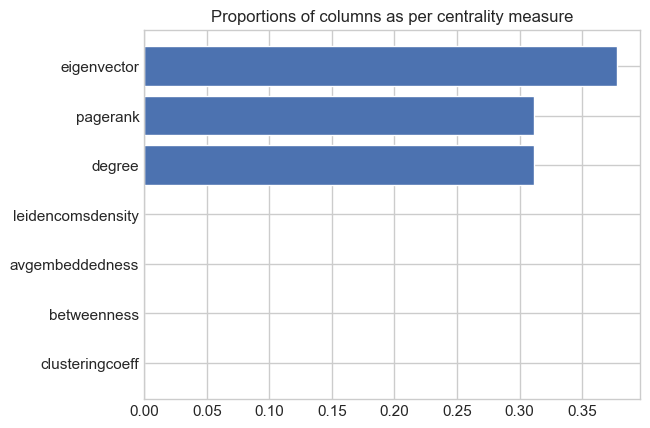

In [134]:
# Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [135]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 415'

'Columns whose impt is 0: 161'

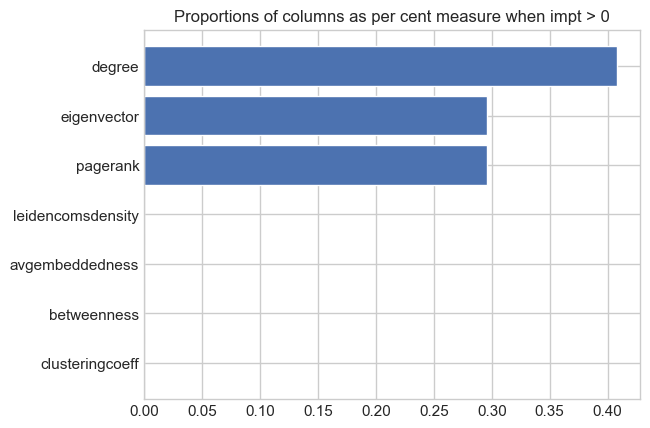

In [136]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


eig_Cfourteen_ck_Ceighteen       0.323855
eig_Ctwentyone_ck_devicemodel    0.167575
pr_Ctwentyone_ck_devicemodel     0.026783
deg_Cseventeen_ck_Csixteen       0.025131
pr_Ctwentyone_ck_appid           0.024722
Name: imp, dtype: float32

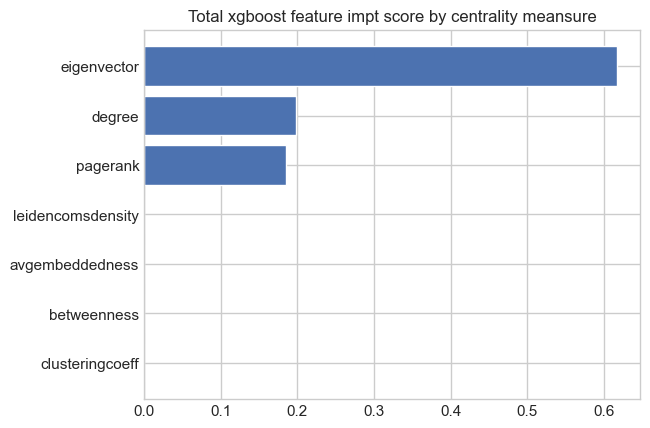

In [137]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs
Deriving features directly from graphs


In [141]:
# 21.0 Path where .gml files are placed:

pathToFolder = avazugraphs
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Read back data files

In [142]:
# 21.1 Just to recapitulate:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [143]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       # 
test_trans.shape    # (499831, 591)
y_test.shape        # 

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_id', 'device_id']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

# 
gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

(1499493, 576)

(499831, 576)

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

0

In [145]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

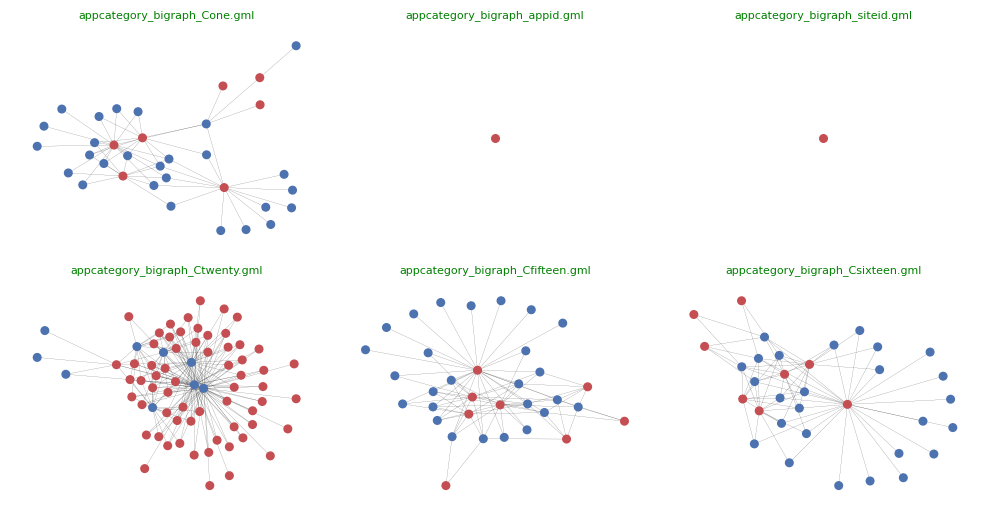

In [146]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 avazugraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

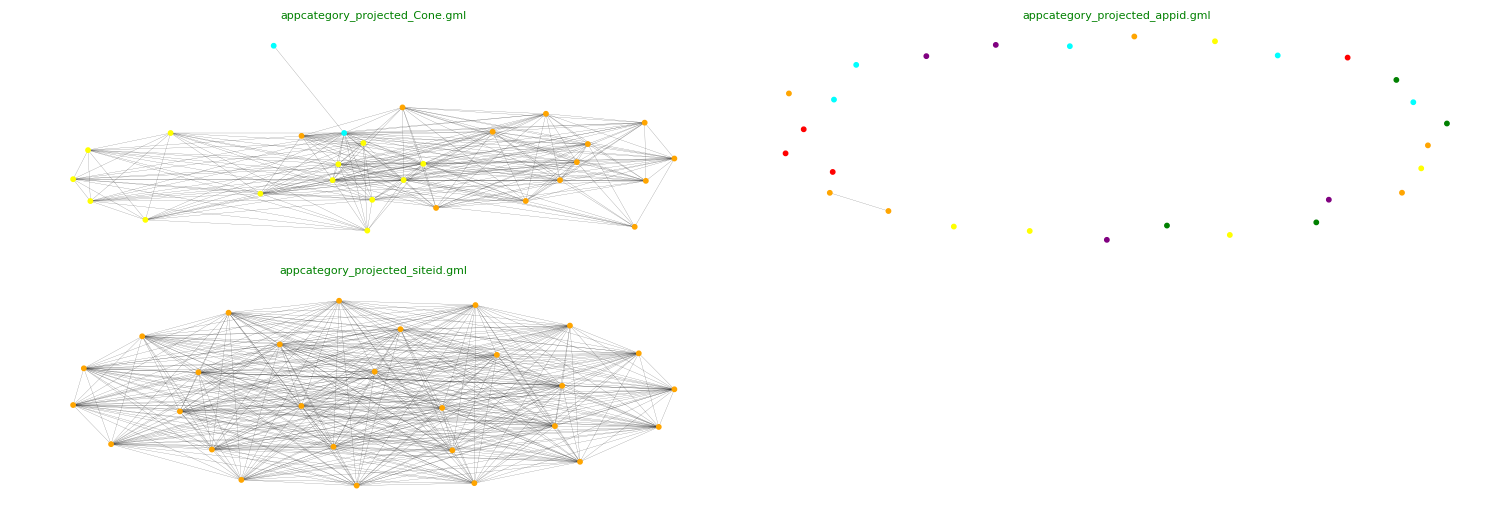

In [147]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   avazugraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [148]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

In [149]:
# $$$$$
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499493, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499831, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1499493, 212)


--



(499831, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,0,0,0,0,0,0


In [150]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1499493, 212)
Datashape after processing: (1499493, 161)


In [151]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazudata)
utils.savePythonObject(fg_te, "fg_te.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\avazu\allmodels\datafiles\fg_te.pkl


In [152]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazudata )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazudata )
fg_tr[0].shape  # (1501119, 161)/(1499493, 161)
fg_te[0].shape  # (500374, 161)/(499831, 161)

(1499493, 161)

(499831, 161)

In [153]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,0,1,1,0,0,0,0


## xgboost modeling with data transformed through community classes

In [155]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:05:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:05:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4044 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73636	validation_1-auc:0.73064
[13:05:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3798 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73914	validation_1-auc:0.73256
[13:05:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3880 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.74059	validation_1-auc:0.73384
[13:05:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3830 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74183	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [156]:
# Save model object:

utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans_commu.pkl


In [158]:
# Restore model object:

model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", avazudata)

### Learning curve

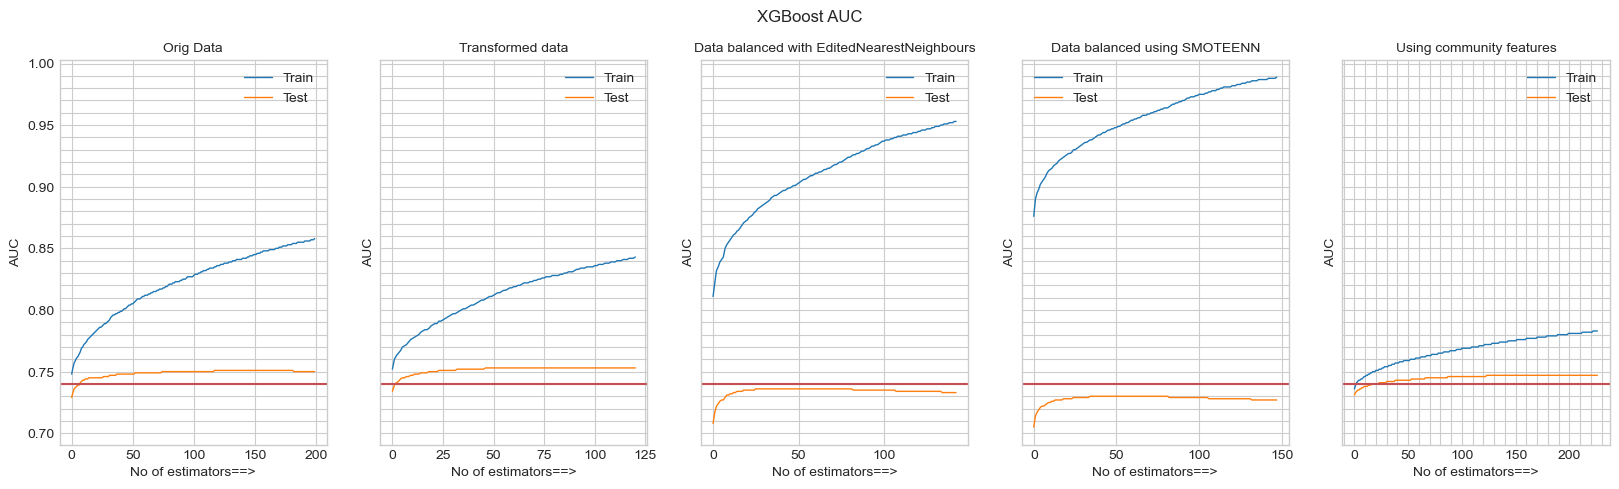

In [159]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result(), model_trans_commu.evals_result()]
title = ["Orig Data", "Transformed data", "Data balanced with EditedNearestNeighbours", 'Data balanced using SMOTEENN',"Using community features" ]
fig.suptitle("XGBoost AUC")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();

#### Classification report

In [160]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.60      0.08      0.15     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [161]:
gc.collect()

10471

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

In [162]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       # (1501119,)
test_trans.shape    # (499831, 591)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (499831, 576)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

(1499493, 576)

(499831, 576)

In [163]:

# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 63060

0

---


63060

In [164]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()


SimpleImputer(strategy='median')

0

In [165]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [167]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

# 22.0 Derive unit vectors:

p = Path(avazuunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = avazuunitvecs ,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = avazuunitvecs ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\avazu\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for ba

## Save unit-vectors files to gdrive
Also save output dictionaries for later use


In [168]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", avazuunitvecs )
utils.savePythonObject(vec_te, "vec_te.pkl",avazuunitvecs )


Object saved to: D:\avazu\allmodels\unitvec\vec_tr.pkl
Object saved to: D:\avazu\allmodels\unitvec\vec_te.pkl


## Restore unit-vectors files from gdrive

In [169]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", avazuunitvecs )
vec_te = utils.restorePythonObject("vec_te.pkl",avazuunitvecs )

In [170]:
## Using unit vectors to transform train/test data

# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


# 23.1

cctr.head(3)
ccte.head(3)


Performing PCA for siteid for train data
Performing PCA for siteid for test data
Performing PCA for sitedomain for train data
Performing PCA for sitedomain for test data
Performing PCA for sitecategory for train data
Performing PCA for sitecategory for test data
Performing PCA for appid for train data
Performing PCA for appid for test data
Performing PCA for appdomain for train data
Performing PCA for appdomain for test data
Performing PCA for appcategory for train data
Performing PCA for appcategory for test data
Performing PCA for devicemodel for train data
Performing PCA for devicemodel for test data
Performing PCA for Cfourteen for train data
Performing PCA for Cfourteen for test data
Performing PCA for Cseventeen for train data
Performing PCA for Cseventeen for test data
Performing PCA for Cnineteen for train data
Performing PCA for Cnineteen for test data
Performing PCA for Ctwenty for train data
Performing PCA for Ctwenty for test data
Performing PCA for Ctwentyone for train dat

,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,-6.798874,-0.691314,0.296195,0.291147,-6.619606,-0.627365,0.151945,0.775774,0.126700,-1.780056,...,0.202847,-0.230138,-4.513250,0.170535,0.762562,0.097961,-0.650808,0.691382,0.174258,0.523408
1,-6.799143,-0.639523,0.293880,0.313999,-6.619864,-0.602760,0.161702,0.772852,0.126465,-1.751921,...,1.473862,-0.320090,4.193050,-3.368114,-0.986932,0.359503,1.801481,2.022496,-2.600278,-0.850639
2,-6.799144,-0.643132,0.305387,0.299861,-6.619863,-0.606134,0.171004,0.806977,0.126558,-1.752252,...,0.271198,-0.335760,3.630827,-0.453982,-1.034530,0.762020,-0.651135,0.686474,0.173932,0.500778


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,-6.799152,-0.643020,0.305116,0.302899,-6.619940,-0.603273,0.163155,0.774594,0.126566,-1.752224,...,2.936947,-4.478351,9.761450,-0.166090,-0.404785,1.265119,-5.978262,-2.440008,-3.740275,-0.829514
1,3.860930,1.221719,-3.612671,5.410371,5.330374,-5.361674,5.669805,-3.693177,-4.373366,2.267525,...,0.187011,-1.293805,10.930211,-1.566389,-4.715336,1.071923,3.437179,3.214548,-2.816512,0.690224
2,-6.799152,-0.643020,0.305116,0.302899,-6.619940,-0.603273,0.163155,0.774594,0.126566,-1.752224,...,-0.443190,1.203392,-4.513707,0.129998,0.783852,0.075119,-1.033178,-0.353883,1.943528,-0.746284


In [171]:

# 23.2

cctr.shape   #  (1499493, 48)
ccte.shape   #  (499831, 48)


(1499493, 48)

(499831, 48)

### Save unitvectors transformed train/test


In [172]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(avazuunitvecs  / "cctr.pkl")
ccte.to_pickle(avazuunitvecs  / "ccte.pkl")


### Readback unitvectors transformed train/test



In [173]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")

In [174]:
# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)
ccte.shape # (499684, 48)


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,-6.798874,-0.691314,0.296195,0.291147,-6.619606,-0.627365,0.151945,0.775774,0.126700,-1.780056,...,0.202847,-0.230138,-4.51325,0.170535,0.762562,0.097961,-0.650808,0.691382,0.174258,0.523408
1,-6.799143,-0.639523,0.293880,0.313999,-6.619864,-0.602760,0.161702,0.772852,0.126465,-1.751921,...,1.473862,-0.320090,4.19305,-3.368114,-0.986932,0.359503,1.801481,2.022496,-2.600278,-0.850639


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,-6.799152,-0.643020,0.305116,0.302899,-6.619940,-0.603273,0.163155,0.774594,0.126566,-1.752224,...,2.936947,-4.478351,9.761450,-0.166090,-0.404785,1.265119,-5.978262,-2.440008,-3.740275,-0.829514
1,3.860930,1.221719,-3.612671,5.410371,5.330374,-5.361674,5.669805,-3.693177,-4.373366,2.267525,...,0.187011,-1.293805,10.930211,-1.566389,-4.715336,1.071923,3.437179,3.214548,-2.816512,0.690224


(1499493, 48)

(499831, 48)

## xgboost modeling

In [175]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[13:58:48] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:58:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3968 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73065	validation_1-auc:0.66136
[13:58:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3576 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73660	validation_1-auc:0.66060
[13:58:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3860 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.73801	validation_1-auc:0.66142
[13:58:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3794 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.73895	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [177]:
utils.savePythonObject(model_vec, "model_vec.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_vec.pkl


In [178]:
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

In [176]:
# 24.2 Best scores:

model_vec.best_score   # 0.7198137939093349
print("\n")
model_vec.best_iteration  # 199


0.7198137939093349

199

### Classification report

In [179]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))


              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.61      0.08      0.14     84744

    accuracy                           0.84    499831
   macro avg       0.73      0.53      0.52    499831
weighted avg       0.80      0.84      0.78    499831



### Learning curve

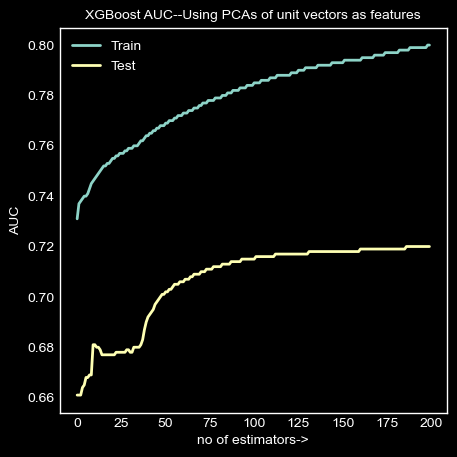

In [180]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

## Feature Engineering with clustering

In [181]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)



Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32
Current index:  36
Current index:  40
Current index:  44


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,-6.798874,-0.691314,0.296195,0.291147,-6.619606,-0.627365,0.151945,0.775774,0.126700,-1.780056,...,0,6,4,1,0,6,5,1,2,5
1,-6.799143,-0.639523,0.293880,0.313999,-6.619864,-0.602760,0.161702,0.772852,0.126465,-1.751921,...,0,1,3,1,0,0,0,5,3,2
2,-6.799144,-0.643132,0.305387,0.299861,-6.619863,-0.606134,0.171004,0.806977,0.126558,-1.752252,...,0,6,4,1,5,6,5,1,4,5


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,-6.799152,-0.643020,0.305116,0.302899,-6.619940,-0.603273,0.163155,0.774594,0.126566,-1.752224,...,0,5,1,1,1,5,5,9,8,7
1,3.860930,1.221719,-3.612671,5.410371,5.330374,-5.361674,5.669805,-3.693177,-4.373366,2.267525,...,2,0,0,0,1,6,5,9,8,2
2,-6.799152,-0.643020,0.305116,0.302899,-6.619940,-0.603273,0.163155,0.774594,0.126566,-1.752224,...,0,6,1,1,5,6,5,0,2,0


In [184]:
# 25.2 Have a look at clusters created:

colNames = [i for i in fe_tr.columns if "clu" in i] 

fe_tr[colNames].head()
fe_te[colNames].head()


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,0,6,4,1,0,6,5,1,2,5
1,1,2,0,1,3,1,0,0,0,5,3,2
2,1,2,0,6,4,1,5,6,5,1,4,5
3,1,2,0,1,3,1,5,2,1,1,6,4
4,1,2,0,5,1,1,1,5,0,6,4,0


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,0,5,1,1,1,5,5,9,8,7
1,4,3,2,0,0,0,1,6,5,9,8,2
2,1,2,0,6,1,1,5,6,5,0,2,0
3,4,3,2,0,0,0,5,2,1,0,2,4
4,0,1,0,0,0,0,5,2,1,1,3,5


In [185]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[14:07:30] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[14:07:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.67707	validation_1-auc:0.67736
[14:07:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.67887	validation_1-auc:0.67930
[14:07:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.68350	validation_1-auc:0.68396
[14:07:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.68376	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [186]:
model_fe.best_score  # 0.7283096238890221

model_fe.best_iteration # 1810

0.7283096238890221

1810

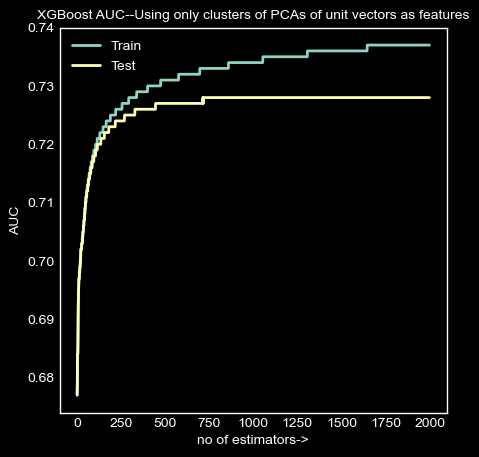

In [187]:

# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [189]:


# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = avazuunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\avazu\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
############# Done ###############

## ROUGH WORK

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'device_id',  'device_ip']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

# 
gc.collect()

In [10]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.849631,-0.462719,0.560084,0.103338,-0.274097,-0.368581,-0.839830,0.391659,-0.459640,0.165295,...,-0.235170,0.191174,0.061168,1.091684,-0.014206,0.195178,-0.525828,0.365271,-0.450755,0.633413
1,1.155139,0.278564,0.410264,-1.244982,0.711136,2.161509,1.152552,-0.602603,1.328864,-1.608991,...,7.061366,-0.712683,0.027135,-0.952509,3.091211,1.870719,-0.473455,-3.947109,3.381505,1.684289
2,-0.679183,-0.699284,-0.083493,0.025313,-0.233486,0.085268,-0.849323,0.032845,-0.439538,0.117099,...,0.224154,-0.034428,0.339811,0.868301,-0.223116,-1.030807,-0.455839,0.140223,-0.364641,0.703816


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.771130,-0.453043,0.095163,0.557658,-0.344208,-0.033671,-0.710520,0.435808,-0.115957,1.102022,...,0.177579,-0.462857,-0.303582,-0.536073,-0.035448,-0.485754,-0.589400,0.886848,-0.017880,-0.268141
1,-0.752837,-0.339575,0.088783,-1.141025,-0.199802,0.185162,0.043599,0.124799,-1.227015,0.896823,...,-0.518168,-0.111798,0.725304,-0.462391,-0.174001,-0.462952,1.012376,-1.013665,-0.281133,-0.180926
2,-0.827908,-0.954810,-0.000639,-0.099604,0.415293,-0.110808,0.136972,-0.378553,-1.093366,0.855857,...,-0.710794,0.551108,0.100063,0.058558,-0.215256,-0.200750,0.266654,-0.267910,0.074544,0.263067


In [21]:
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTEENN

In [12]:
inst = InstanceHardnessThreshold()
start = time.time()
X_res, y_res = inst.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [13]:
X_res.shape  # (548699, 97)
y_res.shape  # (548699,)

(548699, 97)

(548699,)

In [14]:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )
     

[15:00:36] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:00:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3780 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.93528	validation_1-auc:0.69267
[15:00:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3834 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.94281	validation_1-auc:0.69800
[15:00:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3868 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.94824	validation_1-auc:0.70308
[15:00:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4184 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.95010	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [16]:
# 24.3 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(ytest,pred_km))


              precision    recall  f1-score   support

           0       0.94      0.41      0.58    414878
           1       0.23      0.88      0.37     84806

    accuracy                           0.49    499684
   macro avg       0.59      0.65      0.47    499684
weighted avg       0.82      0.49      0.54    499684



In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_km.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
cm = confusion_matrix(y_test, pred_km, labels=model_km.classes_)

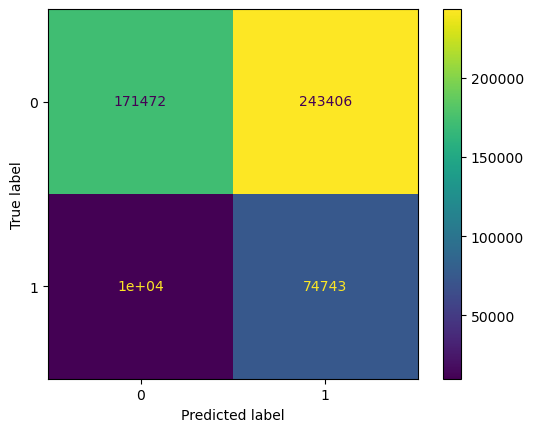

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_km.classes_)
disp.plot()

In [23]:
ncr = NeighbourhoodCleaningRule()
start = time.time()
X_res_ncr, y_res_ncr = ncr.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


35.54191811879476


In [24]:
X_res_ncr.shape  # (1086165, 97)
y_res_ncr.shape  # (1086165, )

(1086165, 97)

(1086165,)

In [25]:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res_ncr
test_X =  pca_test
ytrain =  y_res_ncr
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )
     

[05:24:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:24:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4136 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.78990	validation_1-auc:0.70346
[05:24:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80119	validation_1-auc:0.71216
[05:24:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4058 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.80691	validation_1-auc:0.71571
[05:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4020 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.81086	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [27]:
model_ncr.best_score  # 0.73726971

0.7372697120689804

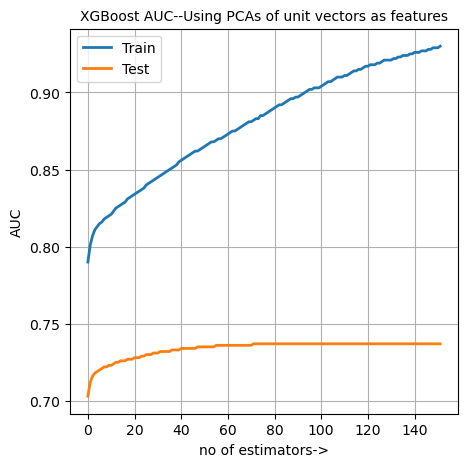

In [28]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_ncr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [29]:
# 24.3 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(ytest,pred_ncr))


              precision    recall  f1-score   support

           0       0.87      0.88      0.87    414878
           1       0.37      0.35      0.36     84806

    accuracy                           0.79    499684
   macro avg       0.62      0.61      0.62    499684
weighted avg       0.78      0.79      0.79    499684

